## Fixed and Randomly Generated Parameters

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import math

fwhm = 5
box_size = 15

## The seeing function will be centered somewhere in x- and y-positions 3 to 11, inclusive

# x_injected = np.random.uniform(3, 11)
# y_injected = np.random.uniform(3, 11)

## The seeing function height will be between 1 and 3

# h_injected = np.random.uniform(1, 3)

## Just hard-code these parameters for now

(a1, ax, ay, axx, axy, ayy, h_injected, x_injected, y_injected, ) = (1.5, 0.75, 1.25, -1.35, 1.45, 1.55, 2.5, 7.4, 3.5)

## Make Fake Data

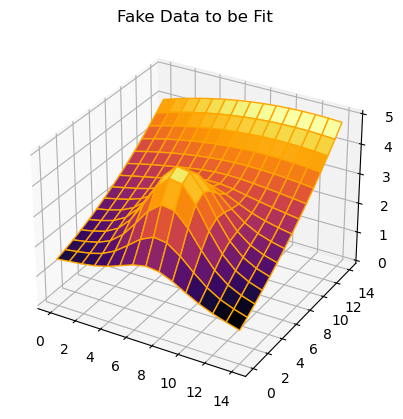

In [2]:
sigma_squared = (fwhm / 2)**2 / math.log(2)

def centered_seeing_function(x, y):
    distance_squared = x**2 + y**2
    return math.exp(-distance_squared / sigma_squared)

def make_model(background, x_slope, y_slope, axx, axy, ayy, height, x_pos, y_pos):
    def model(x, y):
        return (
            background +
            x_slope * x / box_size +
            y_slope * y / box_size +
            axx * x**2 / box_size**2 +
            axy * x * y / box_size**2 +
            ayy * y**2 / box_size**2 +
            height * centered_seeing_function(x - x_pos, y - y_pos)
        )

    return model

data_generator = make_model(a1, ax, ay, axx, axy, ayy, h_injected, x_injected, y_injected)

x_positions = range(box_size)
y_positions = range(box_size)

samples = [[data_generator(i, j) for i in x_positions] for j in y_positions]

x = np.outer(x_positions, np.ones(box_size)).T
y = np.outer(y_positions, np.ones(box_size))
data = np.array(samples)
 
fig = plt.figure()
 
# syntax for 3-D plotting
axes = plt.axes(projection='3d')
axes.plot_surface(x, y, data, cmap='inferno', edgecolor='orange')
axes.set_title('Fake Data to be Fit')
axes.axes.set_zlim3d(bottom=0, top=5)

plt.show()

# The numpy convention when converting a nested list to an array is
# that the most-rapidly varying index stays last, which sort of makes sense.
#
# To be concrete, samples[int(y0)][int(x0)] will be near the peak:
#
# inty0 = int(y0)
# intx0 = int(x0)
#
# (samples[inty0][intx0], data[inty0, intx0], h0)
#
# The above few lines will reveal values that are nearly h0.

## Use scipy.optimize to &ldquo;Discover&rdquo; the Peak in this &ldquo;Data&rdquo;

In [3]:
def variance(model, data):
    shape = data.shape
    sum = 0.0
    for j in range(shape[0]):
        for i in range(shape[1]):
            difference = model(i, j) - data[j, i]
            sum += difference**2
    return sum


In [4]:
BACKGROUND_PARAMETER_INDEX = 0
LINX_SLOPE_PARAMETER_INDEX = 1
LINY_SLOPE_PARAMETER_INDEX = 2
QUADRATIC_XX_PARAMETER_INDEX = 3
QUADRATIC_XY_PARAMETER_INDEX = 4
QUADRATIC_YY_PARAMETER_INDEX = 5
PEAK_PIXEL_PARAMETER_INDEX = 6
POSITION_X_PARAMETER_INDEX = 7
POSITION_Y_PARAMETER_INDEX = 8

def objective_function(model_parameters, data):
    background = model_parameters[BACKGROUND_PARAMETER_INDEX]
    linx_slope = model_parameters[LINX_SLOPE_PARAMETER_INDEX]
    liny_slope = model_parameters[LINY_SLOPE_PARAMETER_INDEX]
    quadratic_xx = model_parameters[QUADRATIC_XX_PARAMETER_INDEX]
    quadratic_xy = model_parameters[QUADRATIC_XY_PARAMETER_INDEX]
    quadratic_yy = model_parameters[QUADRATIC_YY_PARAMETER_INDEX]
    peak_pixel = model_parameters[PEAK_PIXEL_PARAMETER_INDEX]
    position_x = model_parameters[POSITION_X_PARAMETER_INDEX]
    position_y = model_parameters[POSITION_Y_PARAMETER_INDEX]
    model = make_model(background,
                       linx_slope, liny_slope,
                       quadratic_xx, quadratic_xy, quadratic_yy,
                       peak_pixel, position_x, position_y)
    return variance(model, data)


### Make our initial guesses

In [5]:
### Make our initial guesses

background0 = np.median(data)
# background0 = 1.0
linx_slope0 = 0.0
liny_slope0 = 0.0
quadratic_xx0 = 0.0
quadratic_xy0 = 0.0
quadratic_yy0 = 0.0
peak_pixel0 = 1.0
position_x0 = 7.0
position_y0 = 7.0

x0 = (background0,
      linx_slope0, liny_slope0,
      quadratic_xx0, quadratic_xy0, quadratic_yy0,
      peak_pixel0, position_x0, position_y0,)

In [6]:
from scipy.optimize import minimize

result = minimize(objective_function, x0=x0, args=(data,)).x

In [7]:
background = result[BACKGROUND_PARAMETER_INDEX]
linx_slope = result[LINX_SLOPE_PARAMETER_INDEX]
liny_slope = result[LINY_SLOPE_PARAMETER_INDEX]
quadratic_xx = result[QUADRATIC_XX_PARAMETER_INDEX]
quadratic_xy = result[QUADRATIC_XY_PARAMETER_INDEX]
quadratic_yy = result[QUADRATIC_YY_PARAMETER_INDEX]
peak_pixel = result[PEAK_PIXEL_PARAMETER_INDEX]
position_x = result[POSITION_X_PARAMETER_INDEX]
position_y = result[POSITION_Y_PARAMETER_INDEX]

((background, linx_slope, liny_slope, quadratic_xx, quadratic_xy, quadratic_yy, peak_pixel, position_x, position_y), 'vs.', (a1, ax, ay, axx, axy, ayy, h_injected, x_injected, y_injected))

# model = make_model(background, (spike_position_x, spike_position_y), spike_radius, spike_flux)
# values = [[model(i, j) for i in x_positions] for j in y_positions]

((1.4999999380272366,
  0.7500000675887044,
  1.2500001949413988,
  -1.3500000814262962,
  1.4500000685512058,
  1.5499998014444323,
  2.500000040382904,
  7.399999936008501,
  3.499999923288561),
 'vs.',
 (1.5, 0.75, 1.25, -1.35, 1.45, 1.55, 2.5, 7.4, 3.5))